In [1]:
import confirm.berrylib.util as util
util.setup_nb(pretty=False)

from scipy.special import logit, expit
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import warnings
# import pyimprint.grid as grid
import confirm.berrylib.fast_inla as fast_inla
import confirm.mini_imprint.binomial as binomial
import confirm.mini_imprint.grid as grid

import jax
# set to cpu or gpu to run on a specific device.
# jax.config.update('jax_platform_name', 'gpu')

def chunked_simulate(g, sim_size, gridpt_chunk_size=5000, sim_chunk_size=50000):
    theta_tiles = g.theta_tiles
    typeI_sum = np.zeros(theta_tiles.shape[0])
    typeI_score = np.zeros((theta_tiles.shape[0], n_arms))
    n_gridpt_chunks = int(np.ceil(theta_tiles.shape[0] / gridpt_chunk_size))
    n_sim_chunks = int(np.ceil(sim_size / sim_chunk_size))

    for j in range(n_sim_chunks):
        start_sims = j * sim_chunk_size
        end_sims = min(start_sims + sim_chunk_size, sim_size)
        nsims_this_chunk = end_sims - start_sims
        samples = np.random.uniform(size=(nsims_this_chunk, n_arm_samples, n_arms))
        for i in range(n_gridpt_chunks):
            gridpt_start = i * gridpt_chunk_size
            gridpt_end = (i + 1) * gridpt_chunk_size
            gridpt_end = min(gridpt_end, theta_tiles.shape[0])
            sum_chunk, score_chunk = accumulator(
                theta_tiles[gridpt_start:gridpt_end],
                g.null_truth[gridpt_start:gridpt_end],
                samples
            )
            typeI_sum[gridpt_start:gridpt_end] += sum_chunk
            typeI_score[gridpt_start:gridpt_end] += score_chunk
    return typeI_sum, typeI_score

# total, d0, d0u, d1w, d1uw, d2uw = binomial.upper_bound(
#     g.theta_tiles,
#     g.radii[g.grid_pt_idx],
#     g.vertices,
#     np.full(g.n_tiles, sim_size),
#     n_arm_samples,
#     typeI_sum,
#     typeI_score,
# )

In [ ]:
import matplotlib as mpl

In [ ]:
theta, radii = grid.cartesian_gridpts([-1, -1], [1, 1], [2, 2])
null_hypos = [grid.HyperPlane(-np.identity(2)[i], -0.1) for i in range(2)]
g = grid.build_grid(theta, radii, null_hypos)
rects = []
for i in range(g.n_tiles):
    xy = np.min(g.vertices[i], axis=-1)
    width = np.max(g.vertices[i], axis=-1) - xy
    rects.append(mpl.patches.Rectangle(xy, *width, facecolor=None))
plt.gca().add_collection(mpl.patches.PathCollection(rects))

In [2]:
%%time
n_arms = 2
n_arm_samples = 35
fi = fast_inla.FastINLA(n_arms=n_arms, critical_value=0.99)
rejection_table = binomial.build_rejection_table(n_arms, n_arm_samples, fi.rejection_inference)
accumulator = binomial.binomial_accumulator(lambda data: binomial.lookup_rejection(rejection_table, data[...,0]))

CPU times: user 1.94 s, sys: 979 ms, total: 2.92 s
Wall time: 2.86 s


In [45]:
n_theta_1d = 4
theta_min = -3.5
theta_max = 1.0

null_hypos = [
    grid.HyperPlane(-np.identity(n_arms)[i], -logit(0.1)) for i in range(n_arms)
]
theta, radii = grid.cartesian_gridpts(
    np.full(n_arms, theta_min), np.full(n_arms, theta_max), np.full(n_arms, n_theta_1d)
)
start_grid = grid.prune(grid.build_grid(theta, radii, null_hypos))

In [32]:
seed = 10
sim_size = 10000
delta = 0.025

In [40]:
# stop adagrid whenever hob is below this
target_bound = 0.1

# if we can't get below 0.1, refine until the edges are less than 20% above the
# sim pt
target_grid_rel_bound = 0.2
# if we can't get below 0.1, refine until the edges are less than 20% above the
# sim pt
target_sim_rel_bound = 0.2
N_max = int(2e5)

iter_max = 5


In [41]:
def dots_plot(g, typeI_upper_bound, hob):
    plt.subplots(1, 2, figsize=(7, 3.0), constrained_layout=True)
    plt.subplot(1,2,1)
    plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=hob, s=10)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=typeI_upper_bound, s=10)
    plt.colorbar()
    plt.show()

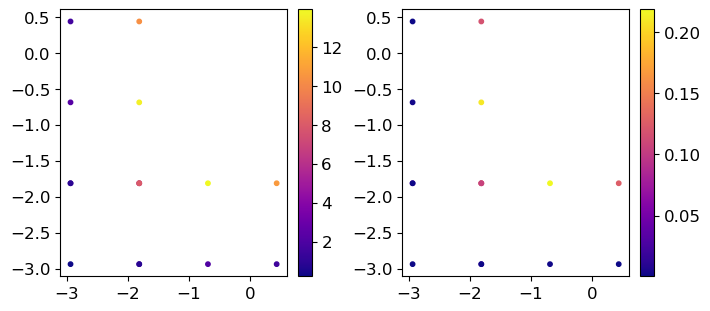

(16,) 0


TypeError: refine_grid() takes 2 positional arguments but 3 were given

In [46]:
new_grid = start_grid
unrefined_grid = None
for ada_i in range(iter_max):
    # TODO: is setting the seed inside the loop okay?
    np.random.seed(seed)
    new_typeI_sum, _ = chunked_simulate(new_grid, sim_size)
    if unrefined_grid is not None:
        g = grid.concat_grids(new_grid, unrefined_grid)
        typeI_sum = np.concatenate((unrefined_typeI_sum, new_typeI_sum))
    else:
        g = new_grid
        typeI_sum = new_typeI_sum

    typeI_est, typeI_CI = binomial.zero_order_bound(typeI_sum, sim_size, delta, 1.0)
    typeI_upper_bound = typeI_est + typeI_CI

    hob = binomial.holder_odi_bound(
        typeI_upper_bound, g.theta_tiles, g.vertices, n_arm_samples, 6
    )
    dots_plot(g, typeI_upper_bound, hob)
    if ada_i == iter_max - 1:
        break

    need_more_sims = typeI_upper_bound > target_bound
    typeI_lower_bound = scipy.stats.beta.ppf(
        1 - delta, typeI_sum, sim_size - typeI_sum + 1
    )
    typeI_lower_bound = np.where(np.isnan(typeI_lower_bound), 0, typeI_lower_bound)
    likely_to_fail = typeI_lower_bound > target_bound
    more_sims = (typeI_upper_bound > target_bound) & (target_bound > typeI_lower_bound)

    need_refine = ((hob - typeI_upper_bound) / typeI_upper_bound > target_grid_rel_bound) & (
        hob > target_bound
    )
    refine_tile_idxs = np.where(need_refine)
    keep_tile_idxs = np.setdiff1d(np.arange(g.n_tiles), refine_tile_idxs[0])
    if refine_tile_idxs[0].shape[0] == 0:
        print('done because no refinement')
        break
    print(refine_tile_idxs[0].shape, keep_tile_idxs.shape[0])

    (new_thetas, new_radii), unrefined_grid, keep_tile_idxs2 = grid.refine_grid(
        g, g.grid_pt_idx[refine_tile_idxs], null_hypos
    )
    new_grid = grid.prune(grid.build_grid(new_thetas, new_radii))
    np.testing.assert_allclose(keep_tile_idxs, keep_tile_idxs2)
    unrefined_typeI_sum = typeI_sum[keep_tile_idxs]